# Taller análisis de crecimiento
Fisiología Vegetal - 2024-01<br>
__Hans D. Escobar H.__

In [24]:
source("main.R")

# plots configuration

# ggplot configuration

theme_set(theme_bw(base_size = 18, base_line_size = 1) +
  theme(
    axis.text = element_text(size = 16),
    text = element_text(size = 18),
    legend.title = element_text(size = 19),
    legend.text = element_text(size = 18)
  ))

plot_base_width <- 15
options(repr.plot.width = plot_base_width)


## 1. Cargar y explorar los datos

In [25]:
data <- read.delim(
  "../Data/FFB.tsv",
  col.names = c("Genotype", "Year", "FFB"),
  colClasses = c("factor", "integer", "double")
)
data %>%
  group_by(Genotype) %>%
  summarize(
    FFB_min = min(FFB), FFB_median = median(FFB), FFB_max = max(FFB),
    Years_min = min(Year), Years_max = max(Year)
  )


Genotype,FFB_min,FFB_median,FFB_max,Years_min,Years_max
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>
(Djongo x Ekona) x Yangambi,2.2,31.6,35.6,3,11
Deli x AVROS,5.4,34.9,43.8,3,11
Deli x AVROS Dumpy,11.2,32.3,42.5,3,11
Deli x Ghana,7.6,32.4,43.6,3,11
Deli x La Mé,3.9,29.8,34.7,3,11
Deli x Nigeria,8.1,31.1,43.3,3,11
Deli x Yangambi,12.5,31.1,36.8,3,11


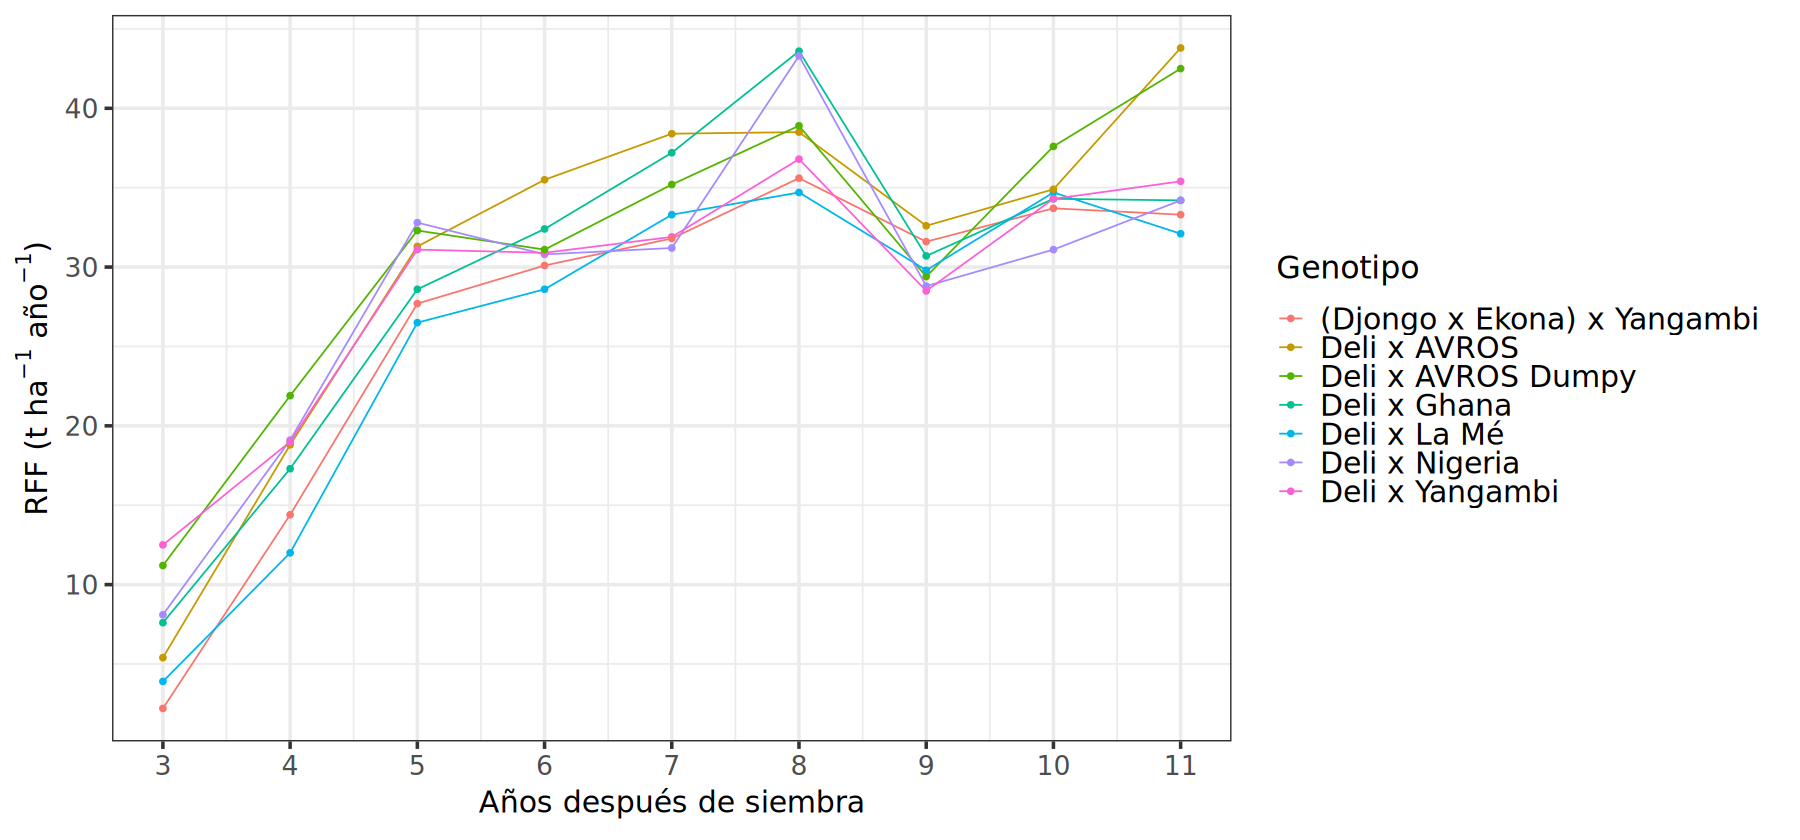

In [26]:
ggplot(
  data = data,
  mapping = aes(x = Year, y = FFB, group = Genotype, color = Genotype)
) +
  geom_line() +
  geom_point() +
  scale_x_continuous(breaks = unique(data$Year)) +
  labs(
    x = expression("Años después de siembra"),
    y = expression("RFF" ~ "(" * t ~ ha^{
      -1
    } ~ año^
      {
        -1
      } * ")"),
    color = expression("Genotipo")
  )


## 2. Identificando el modelo de regresión más apropiado

El coeficiente de determinación $(\mathbf{R}^2)$ __no__ es adecuado para medir la bondad de ajuste de modelos __no__ lineales. En modelos no lineales no se conserva una propiedad que sí tienen los modelos lineales y, en consecuencia, puede tener valores negativos, no es una medida de la variabilidad explicada por el modelo y su uso puede llevar a interpretaciones erradas.

Es más pertinente el uso de otras herramientas tales como el criterio de información de Akaike (AIC) (Burnham & Anderson, 1998) o el pseudo-$\mathbf{R}^2$ (Schabenberger & Pierce, 2001). Tener presente que:

- Sí la razón $\frac{n}{n_{par}} \leq 40$, donde $n$ es el número de observaciones y $n_{par}$ el número de parámetros del modelo, debe usarse el criterio corregido $AICc$ (Burnham & Anderson, 1998).

- Teóricamente, pseudo-$\mathbf{R}^2$ puede tener valores negativos en modelos no lineales. Recordar tambien que no es una medida de variabilidad explicada (Schabenberger & Pierce, 2001).

❗ También se trato con Weibull y logístico de cuatro parámetros, pero fallaron en casi la mitad de los grupos.

In [27]:
tested_models <- test_nls_models(
  data,
  group = "Genotype",
  response = "FFB", explanatory = "Year"
)

tested_models[["goodness"]] %>%
  group_by(model) %>%
  summarize(
    AICc_mean = mean(AICc),
    pseudo_R_square_mean = mean(pseudo_R_square),
    significative_proportion_mean = mean(significative_proportion)
  ) %>%
  arrange(AICc_mean, desc(pseudo_R_square_mean))


model,AICc_mean,pseudo_R_square_mean,significative_proportion_mean
<fct>,<dbl>,<dbl>,<dbl>
logistic,55.27976,0.8917893,0.9523810
gompertz,55.41310,0.8885646,0.6190476
asymptotic,57.55046,0.8746574,0.4285714
asymptotic_origin,63.43411,0.6549889,0.7857143


El modelo logístico presenta el menor AICc y el mayor pseudo-$\mathbf{R}^2$, por ambos criterios es modelo con mejor ajuste.

In [28]:
models_to_use <- filter_models(tested_models, "logistic")

model_parameters <- data.frame(
  t(sapply(
    names(models_to_use),
    FUN = function(x) {
      p.value <- shapiro.test(residuals(models_to_use[[x]]))[["p.value"]]
      c(
        list(
          Genotype = x,
          shapiro_p.value = p.value,
          PASS = p.value >= 0.05
        ),
        coefficients(models_to_use[[x]])
      )
    }, USE.NAMES = FALSE
  )),
  stringsAsFactors = TRUE
) %>%
  mutate_at("Genotype", function(x) as.factor(unlist(x))) %>%
  mutate_at(2:6, unlist) %>%
  arrange(desc(Asym))

model_parameters


Genotype,shapiro_p.value,PASS,Asym,xmid,scal
<fct>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
Deli x AVROS,0.37621890,TRUE,37.55816,4.020467,0.5981842
Deli x AVROS Dumpy,0.81954995,TRUE,36.67457,3.659416,0.8746044
Deli x Ghana,0.18498702,TRUE,35.92686,4.024487,0.7323117
Deli x Nigeria,0.09308834,TRUE,33.64474,3.744254,0.5748537
Deli x Yangambi,0.76238787,TRUE,33.60207,3.550506,0.8450438
(Djongo x Ekona) x Yangambi,0.52555299,TRUE,32.91185,4.158786,0.5163619
Deli x La Mé,0.40309937,TRUE,32.71657,4.274316,0.6020639


En todos los grupos el error se ajusta a una distribución normal.

## 3. Caracterizar la producción

La función logística que se ajustó tiene la forma:

$$f(x) = \frac{A}{1 + \mathrm{e}^{(x_{mid} - x)/s}}$$

Donde, $A$ es la asíntota (Asym), $s$ un factor de escala reciproco a la tasa de crecimiento logística (scale), y $x_{mid}$ el punto medio y de inflexión (xmid). 

Se caracterizará la producción empleando los puntos críticos de la curva logística (Mischan et al., 2011; Sari et al., 2018):

- Producción máxima: $A$ (Asym).
- Precocida: el tiempo $x$ al que se llega a punto de inflexión; es decir, $x_{mid}$.
- Eficiencia productiva: el valor de $f^\prime$ en el punto donde $f^{\prime \prime} = 0$; es decir, $f^\prime(x_{mid})$.
- Año en el que se alcanza la máxima productividad: punto de inició de la desaceleración asintótica. Corresponde al ultimo punto de inflexión de la aceleración $(f^{\prime \prime})$; es decir, el mayor $x$ donde $f^{\prime \prime \prime \prime}(x) = 0$

Adicionalmente toca determinar el estimado de productividad total en un ciclo productivo (desde que se empieza a cosechar) de 25 años. Para esto debe bastar con la integral de $f$ en el intervalo $x \in [0, 25]$; sin embargo, hay que resaltar que 25 años, por lo general, incluyen la etapa de envejecimiento o senescente, donde la producción de frutos comienza a decaer (Corley & Tinker, 2015; Foong et al., 2019). Nuestros datos son de 13 años, por lo que el modelo no incluye está etapa.Por lo tanto, esta medida sobrestima la productividad total, además de no tener en cuenta potenciales diferencias en la edad de senescencia entre los genotipos.

### 3.1. Integral y derivadas de la función logística empleada

Las formulas fueron obtenidas mediante computación simbólica empleando la biblioteca de Python, SymPy 1.13.3


- Eficiencia productiva:
$$\frac{A}{4 \cdot \mathcal{s}}$$
- Año al que se llega a máxima productividad:
$$\mathcal{s} \cdot \log{\left(2 \sqrt{6} + 5 \right)} + x_{mid}$$
- Integral:
$$A \left(\mathcal{s} \cdot \log{\left(e^{\frac{- x + xmid}{\mathcal{s}}} + 1 \right)} + x\right)$$

### 3.2.Caracterizando la productividad de los genotipos

In [36]:
productivity <- model_parameters %>%
  mutate(prod_effic = logis_reprod_effic(Asym, scal)) %>%
  mutate(year_max_prod = logis_year_max_prod(xmid, scal)) %>%
  mutate(total_prod = logis_integral(25, Asym, xmid, scal) -
    logis_integral(0, Asym, xmid, scal)) %>%
  select(-c("shapiro_p.value", "PASS", "scal")) %>%
  rename(max_prod = Asym, precocity = xmid)

productivity


Genotype,max_prod,precocity,prod_effic,year_max_prod,total_prod
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Deli x AVROS,37.55816,4.020467,15.696740,5.391763,787.9257
Deli x AVROS Dumpy,36.67457,3.659416,10.483190,5.664387,782.1718
Deli x Ghana,35.92686,4.024487,12.264879,5.703261,753.4766
Deli x Nigeria,33.64474,3.744254,14.631872,5.062067,715.1154
Deli x Yangambi,33.60207,3.550506,9.940926,5.487711,720.3255
(Djongo x Ekona) x Yangambi,32.91185,4.158786,15.934489,5.342510,685.9176
Deli x La Mé,32.71657,4.274316,13.585171,5.654507,678.0570


### 3.3. Escogiendo un genotipo

"Con base en estos resultados deberá dar recomendaciones de qué cultivar sembrar si quiero flujo de caja
(entrada rápida de capital) estabilidad de producción o máximo de producción en el ciclo productivo de
25 años."

In [39]:
(percent_rank(model_parameters$Asym) +
  percent_rank(model_parameters$logistic_growth_rate) +
  percent_rank(1 / model_parameters$xmid)) / 3


[1] 0.7222222 0.5555556 0.4444444 0.6666667 0.5000000 0.4444444 0.1666667

In [28]:
functions_df <- bind_rows(lapply(
  names(models_to_use),
  FUN = function(name) {
    xs <- seq(0, max(data$Year), 0.1)
    ys <- sapply(
      xs,
      FUN = function(x) {
        c <- coefficients(models_to_use[[name]])
        c[["Asym"]] / (1 + exp((c[["xmid"]] - x) / c[["scal"]]))
      }
    )
    data.frame(Genotype = name, Year = xs, FFB = ys, stringsAsFactors = TRUE)
  }
))


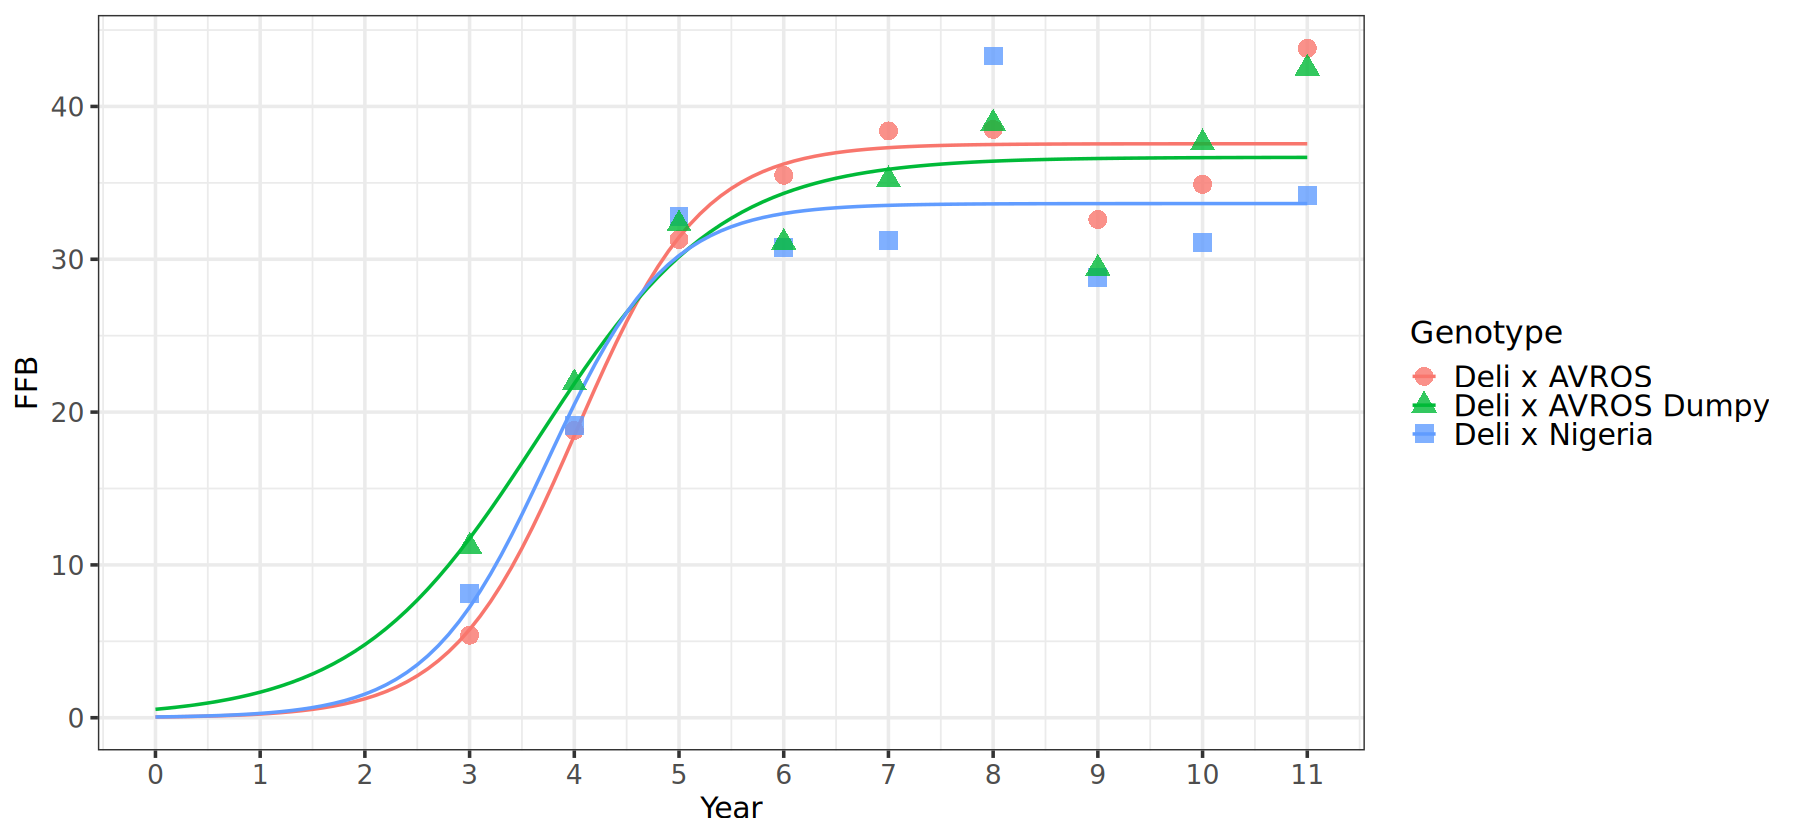

In [41]:
genotypes_to_plot <- c(
  "Deli x AVROS",
  "Deli x AVROS Dumpy",
  # "Deli x Ghana",
  # "(Djongo x Ekona) x Yangambi ",
  # "Deli x La Mé",
  "Deli x Nigeria"
  # "Deli x Yangambi"
)
ggplot(
  data = filter(functions_df, Genotype %in% genotypes_to_plot),
  aes(x = Year, y = FFB, group = Genotype, color = Genotype)
) +
  geom_line(linewidth = 1) +
  scale_x_continuous(breaks = seq(0, max(data$Year))) +
  geom_point(
    data = filter(data, Genotype %in% genotypes_to_plot),
    aes(shape = Genotype), size = 5, alpha = 0.8
  )


## References

Burnham, K. P., & Anderson, D. R. (1998). Practical Use of the Information-Theoretic Approach. In Model Selection and Inference (pp. 75–117). Springer New York. https://doi.org/10.1007/978-1-4757-2917-7_3

Corley, R. H. V., & Tinker, P. B. (2015). The Oil Palm (1st ed.). Wiley. https://doi.org/10.1002/9781118953297

Foong, S. Z. Y., Goh, C. K. M., Supramaniam, C. V., & Ng, D. K. S. (2019). Input–output optimisation model for sustainable oil palm plantation development. Sustainable Production and Consumption, 17, 31–46. https://doi.org/10.1016/j.spc.2018.08.010

Mischan, M. M., Pinho, S. Z. D., & Carvalho, L. R. D. (2011). Determination of a point sufficiently close to the asymptote in nonlinear growth functions. Scientia Agricola, 68(1), 109–114. https://doi.org/10.1590/S0103-90162011000100016

Sari, B. G., Olivoto, T., Diel, M. I., Krysczun, D. K., Lúcio, A. D. C., & Savian, T. V. (2018). Nonlinear Modeling for Analyzing Data from Multiple Harvest Crops. Agronomy Journal, 110(6), 2331–2342. https://doi.org/10.2134/agronj2018.05.0307

Schabenberger, O., & Pierce, F. J. (2001). Nonlinear Models. In Contemporary Statistical Models for the Plant and Soil Sciences (p. 760). CRC Press. https://doi.org/10.1201/9781420040197